In [1]:
# Make Jupyter reload library before every execution

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

df= pd.read_csv('data/all.csv', parse_dates=True, )

In [3]:
# Define mappings for ordinal conversion
age_mapping = {
    "25-34": 30,
    "16-24": 20,
    "35-44": 40,
    "45-54": 50,
    "55+": 60,
}

onset_mapping = {
    "<15 Minutes": 7.5,
    "30-60 Minutes": 45,
    "15-30 Minutes": 20,
    ">60 Minutes": 60,
}

nap_mapping = {
    "No Nap": 0,
    "<30 Minutes": 15,
    "60-90 Minutes": 75,
    "30-60 Minutes": 45,
    ">90 Minutes": 100,
}
exercise_mapping = {"0 Days": 0, "1-2 Days": 1, "3-4 Days": 2, "5+ Days": 3}
sleep_disturbances_mapping = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Often": 4,
}
device_usage_mapping = {
    "<1 Hour": 0,
    "1-3 Hours": 1,
    "3-5 Hours": 2,
    "5-7 Hours": 3,
    "7+ Hours": 4,
}

# Convert 'Exercise Days/Week' and 'Sleep Disturbances' from categorical to ordinal using the defined mappings
df["Age Group Ordinal"] = df["Age Group"].map(age_mapping)
df["Sleep Onset Time Ordinal"] = df["Sleep Onset Time"].map(onset_mapping)
df["Nap Duration Ordinal"] = df["Nap Duration"].map(nap_mapping)
df["Exercise Days/Week Ordinal"] = df["Exercise Days/Week"].map(exercise_mapping)
df["Sleep Disturbances Ordinal"] = df["Sleep Disturbances"].map(
    sleep_disturbances_mapping
)
df["Device Usage (hrs/day) Ordinal"] = df["Device Usage (hrs/day)"].map(
    device_usage_mapping
)

# Select only numerical columns for covariance calculation
numerical_df = df.select_dtypes(include=["number"]).drop(
    ["Height (cm)", "Weight (kg)"], axis=1
)

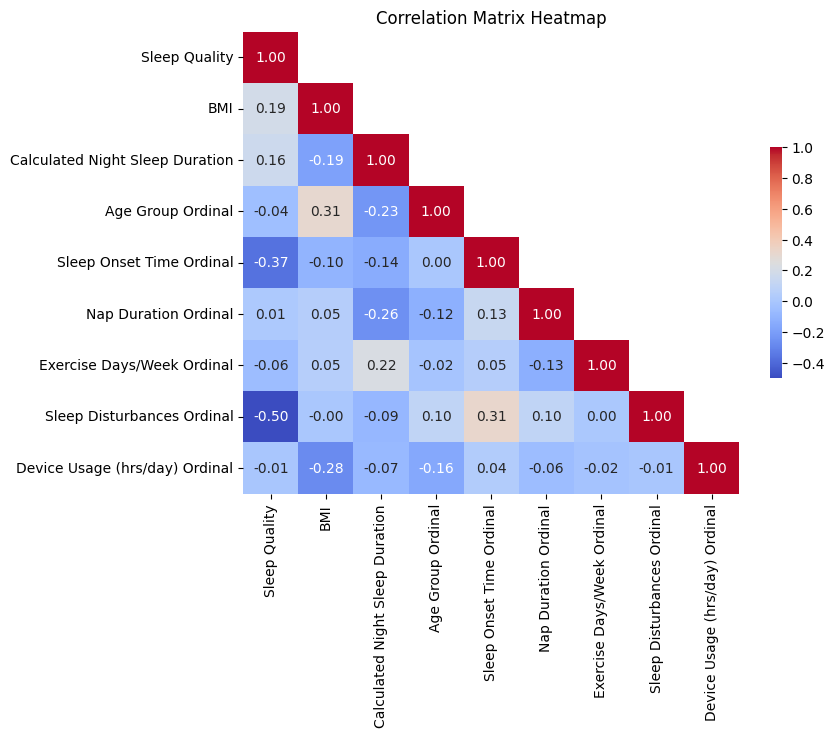

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the covariance matrix
corr_matrix = numerical_df.corr()
matrix = np.triu(corr_matrix, k=1)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink': .5}, mask=matrix)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Linear Regression / Classification

# Some model IDK

# Some model IDK

# Some model IDK